In [9]:
import torch
import torchaudio
import muspy
import numpy as np
import pypianoroll as pypir
from utils import pianoroll2binaryroll, binaryroll2pitchlist, pitchlist2pianoroll, shortpitchlist2pitchlist, midi2audio, add_padding_bar
from utils import UNIT_AS_TICK, BEAT_AS_TICK, BAR_AS_TICK

PATH_PREFIX = 'data_set/'
PATH_PREFIX_Q = 'quantized/'

In [10]:
from pathlib import Path

data_dir = Path(PATH_PREFIX)
file_list = sorted(list(data_dir.rglob('*.mid')))

file_list = [file.name for file in file_list]

In [25]:
relative_semitones_major = {
    'F#': -6,
    'Gb': -6,
    'G': -5,
    'G#': -4,
    'Ab': -4,
    'A': -3,
    'A#': -2,
    'Bb': -2,
    'B': -1,
    'C': 0,
    'C#': 1,
    'Db': 1,
    'D': 2,
    'D#': 3,
    'Eb': 3,
    'E': 4,
    'F': 5
}

relative_semitones_minor = {
    'D#': -6,
    'Eb': -6,
    'E': 5,
    'F': 4,
    'F#': -3,
    'Gb': -3,
    'G': -2,
    'G#': -1,
    'Ab': -1,
    'A': 0,
    'A#': 1,
    'Bb': 1,
    'B': 2,
    'C': 3,
    'C#': 4,
    'Db': 4,
    'D': 5,
}

In [35]:
filenames = file_list[46:48]

midis = [muspy.read(f'{PATH_PREFIX}{filename}') for filename in filenames]

song_titles = [filename.split('.')[0] for filename in filenames]
song_titles = [song_title.split('-') for song_title in song_titles]

bpms = [float(song_title[3]) for song_title in song_titles]

tempo_cleaneds = [midi.deepcopy() for midi in midis]
new_tempos = [muspy.Tempo(0, bpm) for bpm in bpms]

for idx, song in enumerate(tempo_cleaneds):
    song.tempos = [new_tempos[idx]]

keys = [song_title[2] for song_title in song_titles]

transposeds = [song.deepcopy() for song in tempo_cleaneds]

for idx, song in enumerate(transposeds):
    key = keys[idx]
    semitone_dict = relative_semitones_minor if 'm' in key else relative_semitones_major
    
    key = key[:-1]
    semitones_to_transpose = -1 * semitone_dict[key]
    
    song.transpose(semitones_to_transpose)
    
pianorolls = [muspy.to_pypianoroll(song) for song in transposeds]


In [30]:
res_pianoroll_obj = pianorolls[0]
res_pianoroll = res_pianoroll_obj.tracks[0].pianoroll

quantized_pianoroll_obj = pianorolls[0].copy()
before_quantized_pianoroll = quantized_pianoroll_obj.tracks[0].pianoroll
before_quantized_pianoroll_binaryroll = pianoroll2binaryroll(before_quantized_pianoroll)
before_quantized_pianoroll_pitch_list = binaryroll2pitchlist(before_quantized_pianoroll_binaryroll)
# before_quantized_pianoroll_pitch_list = add_padding_bar(before_quantized_pianoroll_pitch_list)

In [31]:
from collections import Counter

len_pitch_list = len(before_quantized_pianoroll_pitch_list)

short_quantized_pianoroll_pitch_list = []

for i in range(0, len_pitch_list, UNIT_AS_TICK):
    sliced = before_quantized_pianoroll_pitch_list[i : i + UNIT_AS_TICK]

    pitch_cnt_dict = dict(Counter(sliced))
    
    max_pitch_cnt_value = max(pitch_cnt_dict.values())
    max_pitch_cnt_pitch = [key for key, val in pitch_cnt_dict.items() if val == max_pitch_cnt_value][0]
    
    short_quantized_pianoroll_pitch_list.append(max_pitch_cnt_pitch)
    

quantized_pianoroll_pitch_list = shortpitchlist2pitchlist(short_quantized_pianoroll_pitch_list)

[<Axes: xlabel='time (beat)', ylabel='\n\npitch'>]

[<Axes: xlabel='time (beat)', ylabel='\n\npitch'>]

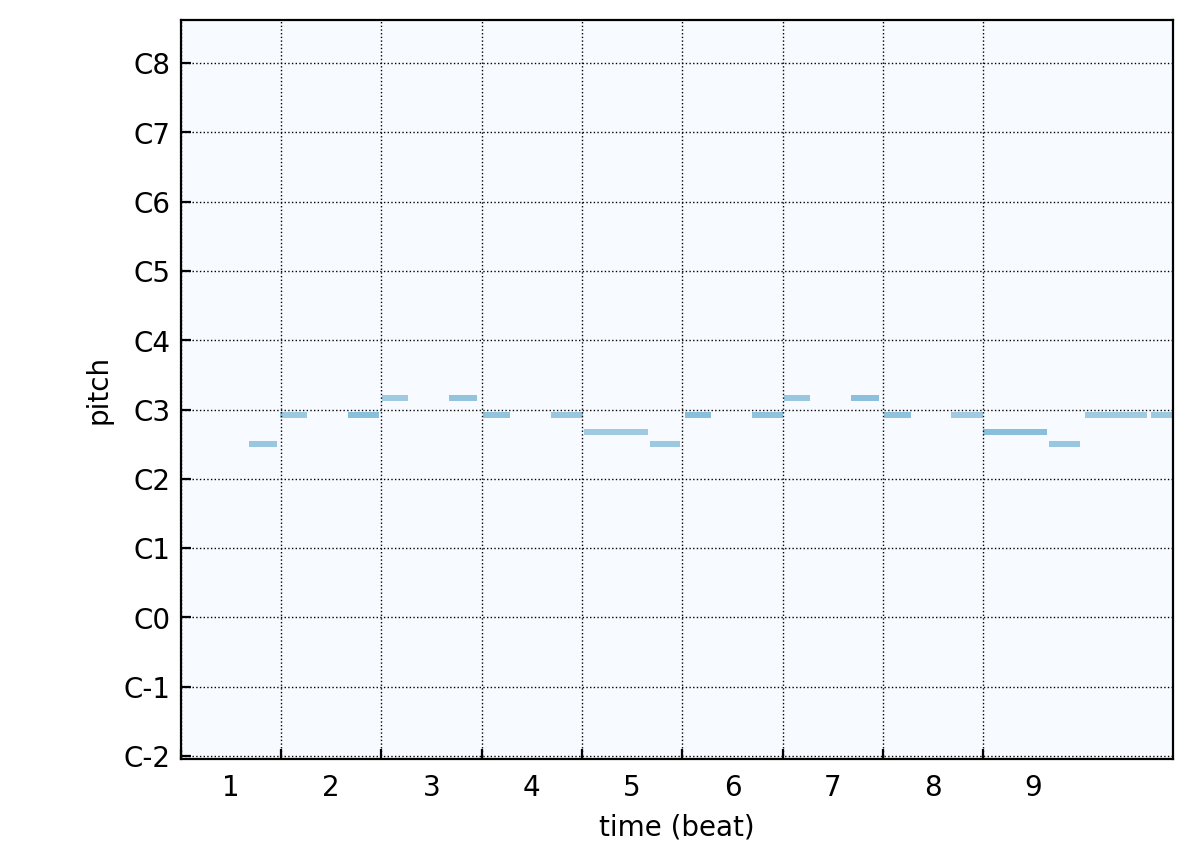

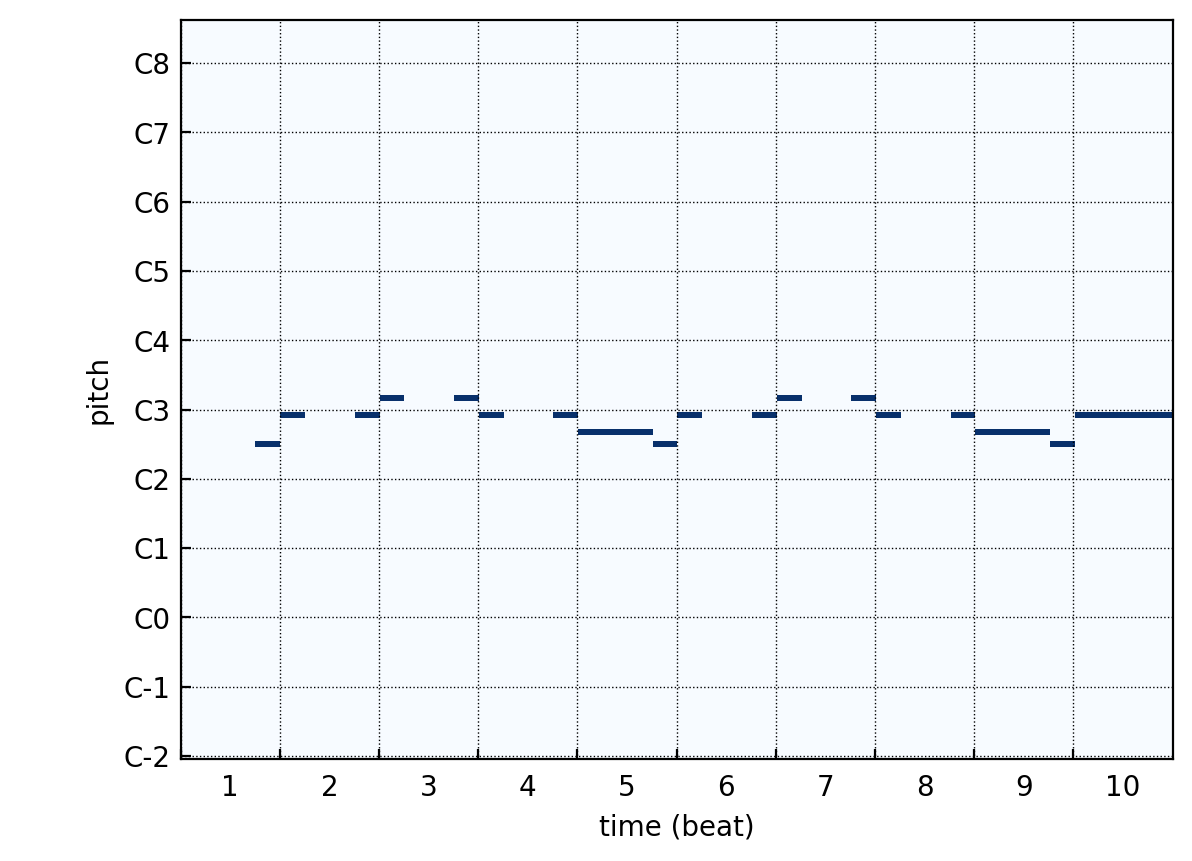

In [32]:
import IPython.display as ipd

quantized_pianoroll_obj.tracks[0].pianoroll = pitchlist2pianoroll(quantized_pianoroll_pitch_list)

ipd.display(res_pianoroll_obj.plot())
ipd.display(quantized_pianoroll_obj.plot())

In [33]:
quantized_song = muspy.from_pypianoroll(quantized_pianoroll_obj)

quantized_song_path_wo_ext = f'{PATH_PREFIX_Q}{filenames[0]}'.split('.')[0]
original_song_path_wo_ext = f'{PATH_PREFIX}{filenames[0]}'.split('.')[0]
muspy.write_midi(f'{quantized_song_path_wo_ext}.mid', quantized_song)

midi2audio(f'{quantized_song_path_wo_ext}.mid', f'{quantized_song_path_wo_ext}.wav')
midi2audio(f'{original_song_path_wo_ext}.mid', f'{original_song_path_wo_ext}.wav')

orig, orig_sr = torchaudio.load(f'{original_song_path_wo_ext}.wav')
quant, quant_sr = torchaudio.load(f'{quantized_song_path_wo_ext}.wav')

ipd.display(ipd.Audio(orig, rate=orig_sr))
ipd.display(ipd.Audio(quant, rate=quant_sr))


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.


FluidSynth runtime version 2.3.1
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'quantized/night_train-4|4-Bb-104-001-3-c.wav'..
FluidSynth runtime version 2.3.1
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'data_set/night_train-4|4-Bb-104-001-3-c.wav'..
